In [1]:
import cmocean.cm as cm
import datetime as dt
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mocsy import mocsy
import gsw
import os
import pandas as pd

from salishsea_tools import viz_tools

In [2]:
mesh = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc')
bathy = xr.open_dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
kk = np.array([0.74711466, 3.54136997, 0.37895037, 7.19318921, 0.42550747])

In [4]:
def growth(k, pH, co2):
    mm = co2/(k[1] + co2)
    tt = k[0] * (1 + k[2] * (1 + np.tanh((pH - k[3]) / k[4])))
    return mm * tt, mm, tt

In [5]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

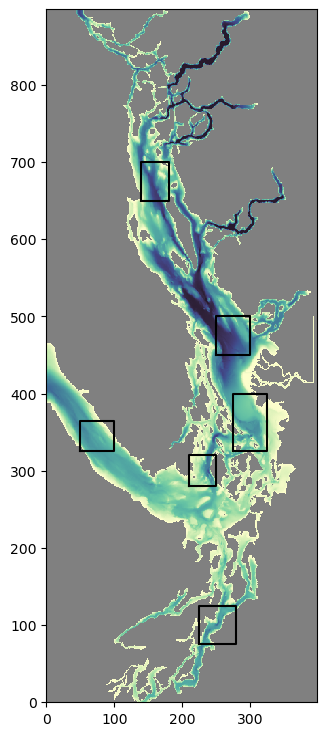

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);
CentralSoG = [450,500, 250, 300]
plot_box(ax, CentralSoG, 'k')

NorthernSoG = [650,700, 140,180]
plot_box(ax, NorthernSoG, 'k')

SouthernSoG = [325,400, 275, 325]
plot_box(ax, SouthernSoG, 'k')

Mixed = [280,320, 210, 250]
plot_box(ax, Mixed, 'k')

JdF = [325,365, 50, 100]
plot_box(ax, JdF, 'k')

PS_main = [75,125, 225, 280]
plot_box(ax, PS_main, 'k')

SS_all = [0, 898, 0, 398]

boxes = [SS_all, SouthernSoG,CentralSoG, NorthernSoG, PS_main, Mixed, JdF]
boxnames = ['SS_all', 'SouthernSoG', 'CentralSoG', 'NorthernSoG', 'PS_main', 'Mixed',
           'JdF']

In [7]:
# needs grid files
def get_tinsitu(files):
    tinsitu = []
    times = []
    skipped_files = []

    for file in files:
        try:
            neutral = xr.open_dataset(file)

            # Check for missing or empty time_centered
            if 'time_centered' not in neutral or neutral.time_centered.size == 0:
                skipped_files.append((file, "missing or empty time_centered"))
                neutral.close()
                continue

            time_val = neutral.time_centered.values[0]
            if np.isnat(time_val):
                skipped_files.append((file, "invalid time (NaT)"))
                neutral.close()
                continue

            # Mask salinity and temperature
            mask = tmask[0, 0:5,
                         SS_all[0]:SS_all[1],
                         SS_all[2]:SS_all[3]]

            sal_masked = np.ma.masked_where(mask == 0,
                                            neutral.vosaline[0, 0:5,
                                                             SS_all[0]:SS_all[1],
                                                             SS_all[2]:SS_all[3]])
            temp_masked = np.ma.masked_where(mask == 0,
                                             neutral.votemper[0, 0:5,
                                                              SS_all[0]:SS_all[1],
                                                              SS_all[2]:SS_all[3]])

            if sal_masked.count() == 0 or temp_masked.count() == 0:
                skipped_files.append((file, "all salinity or temperature values masked"))
                neutral.close()
                continue

            mean_sal = sal_masked.mean()
            mean_temp = temp_masked.mean()

            tinsitu_val = gsw.t_from_CT(mean_sal, mean_temp, 0)
            tinsitu.append(tinsitu_val)
            times.append(time_val)

            neutral.close()

        except Exception as e:
            skipped_files.append((file, f"exception: {e}"))
            continue

    if skipped_files:
        print("\n⚠️ Skipped files summary:")
        for f, reason in skipped_files:
            print(f"  - {f}\n    ↳ {reason}")

    return tinsitu, times


In [8]:
# needs grid files
def get_Spsu(files):
    Spsu = []
    times = []
    skipped_files = []

    for file in files:
        try:
            neutral = xr.open_dataset(file)

            # Check for missing or empty time_centered
            if 'time_centered' not in neutral or neutral.time_centered.size == 0:
                skipped_files.append((file, "missing or empty time_centered"))
                neutral.close()
                continue

            time_val = neutral.time_centered.values[0]
            if np.isnat(time_val):
                skipped_files.append((file, "invalid time (NaT)"))
                neutral.close()
                continue

            # Extract and mask salinity
            sal_data = neutral.vosaline[0, 0:5,
                                        SS_all[0]:SS_all[1],
                                        SS_all[2]:SS_all[3]]
            mask = tmask[0, 0:5,
                         SS_all[0]:SS_all[1],
                         SS_all[2]:SS_all[3]]
            masked_sal = np.ma.masked_where(mask == 0, sal_data)

            if masked_sal.count() == 0:
                skipped_files.append((file, "all salinity values masked"))
                neutral.close()
                continue

            Spsu.append(masked_sal.mean() * 35 / 35.16504)
            times.append(time_val)

            neutral.close()

        except Exception as e:
            skipped_files.append((file, f"exception: {e}"))
            continue

    if skipped_files:
        print("\n⚠️ Skipped files summary:")
        for f, reason in skipped_files:
            print(f"  - {f}\n    ↳ {reason}")

    return Spsu, times


In [9]:
## Needs carp files
def get_TA(files):
    TA = []
    times = []
    skipped_files = []

    for file in files:
        try:
            neutral = xr.open_dataset(file)

            # Check for missing or empty time_centered
            if 'time_centered' not in neutral or neutral.time_centered.size == 0:
                skipped_files.append((file, "missing or empty time_centered"))
                neutral.close()
                continue

            time_val = neutral.time_centered.values[0]
            if np.isnat(time_val):
                skipped_files.append((file, "invalid time (NaT)"))
                neutral.close()
                continue

            # Extract and mask TA
            ta_data = neutral.total_alkalinity[0, 0:5,
                                               SS_all[0]:SS_all[1],
                                               SS_all[2]:SS_all[3]]
            mask = tmask[0, 0:5,
                         SS_all[0]:SS_all[1],
                         SS_all[2]:SS_all[3]]
            masked_ta = np.ma.masked_where(mask == 0, ta_data)

            if masked_ta.count() == 0:
                skipped_files.append((file, "all TA values masked"))
                neutral.close()
                continue

            TA.append(masked_ta.mean() / 1000)
            times.append(time_val)

            neutral.close()

        except Exception as e:
            skipped_files.append((file, f"exception: {e}"))
            continue

    if skipped_files:
        print("\n⚠️ Skipped files summary:")
        for f, reason in skipped_files:
            print(f"  - {f}\n    ↳ {reason}")

    return TA, times


In [10]:
# needs carp files
def get_DIC(files):
    DIC = []
    times = []
    skipped_files = []

    for file in files:
        try:
            neutral = xr.open_dataset(file)

            # Check for missing or empty time_centered
            if 'time_centered' not in neutral or neutral.time_centered.size == 0:
                skipped_files.append((file, "missing or empty time_centered"))
                neutral.close()
                continue

            time_val = neutral.time_centered.values[0]
            if np.isnat(time_val):
                skipped_files.append((file, "invalid time (NaT)"))
                neutral.close()
                continue

            # Extract and mask DIC
            dic_data = neutral.dissolved_inorganic_carbon[0, 0:5,
                                                          SS_all[0]:SS_all[1],
                                                          SS_all[2]:SS_all[3]]
            mask = tmask[0, 0:5,
                         SS_all[0]:SS_all[1],
                         SS_all[2]:SS_all[3]]
            masked_dic = np.ma.masked_where(mask == 0, dic_data)

            if masked_dic.count() == 0:
                skipped_files.append((file, "all DIC values masked"))
                neutral.close()
                continue

            DIC.append(masked_dic.mean() / 1000)
            times.append(time_val)

            neutral.close()

        except Exception as e:
            skipped_files.append((file, f"exception: {e}"))
            continue

    # Optional: Show summary of skipped files
    if skipped_files:
        print("\n⚠️ Skipped files summary:")
        for f, reason in skipped_files:
            print(f"  - {f}\n    ↳ {reason}")

    return DIC, times


In [11]:
files = sorted(glob.glob('/data/sallen/results/MEOPAR/Karyn/Carbon_v202111/Present_Lb80/*/SalishSea_1d*_carp_T.nc'))

# Extract date from filename for true chronological sort
def extract_date(file_path):
    filename = os.path.basename(file_path)
    return filename.split('_')[2]  # This is 'YYYYMMDD'

# Sort files by date in filename
files = sorted(files, key=extract_date)


TA_Lb80, times_Lb80 = get_TA(files)
DIC_Lb80, times_Lb80 = get_DIC(files)


In [12]:
files = sorted(glob.glob('/data/sallen/results/MEOPAR/Karyn/Carbon_v202111/Present_Lb80/*/SalishSea_1d*_grid_T.nc'))

# Extract date from filename for true chronological sort
def extract_date(file_path):
    filename = os.path.basename(file_path)
    return filename.split('_')[2]  # This is 'YYYYMMDD'

# Sort files by date in filename
files = sorted(files, key=extract_date)


tinsitu_Lb80, times_Lb80 = get_tinsitu(files)
Spsu_Lb80, times_Lb80 = get_Spsu(files)

In [13]:
files = sorted(glob.glob('/data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/*/SalishSea_1d*_carp_T.nc'))

# Extract date from filename for true chronological sort
def extract_date(file_path):
    filename = os.path.basename(file_path)
    return filename.split('_')[2]  # This is 'YYYYMMDD'

# Sort files by date in filename
files = sorted(files, key=extract_date)

TA_PI_Lb80, times_PI_Lb80 = get_TA(files)
DIC_PI_Lb80, times_PI_Lb80 = get_DIC(files)


⚠️ Skipped files summary:
  - /data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/30dec11/SalishSea_1d_20111230_20111230_carp_T.nc
    ↳ exception: zero-size array to reduction operation minimum which has no identity

⚠️ Skipped files summary:
  - /data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/30dec11/SalishSea_1d_20111230_20111230_carp_T.nc
    ↳ exception: zero-size array to reduction operation minimum which has no identity


In [14]:
files = sorted(glob.glob('/data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/*/SalishSea_1d*_grid_T.nc'))

# Extract date from filename for true chronological sort
def extract_date(file_path):
    filename = os.path.basename(file_path)
    return filename.split('_')[2]  # This is 'YYYYMMDD'

# Sort files by date in filename
files = sorted(files, key=extract_date)

tinsitu_PI_Lb80, times_PI_Lb80 = get_tinsitu(files)
Spsu_PI_Lb80, times_PI_Lb80 = get_Spsu(files)


⚠️ Skipped files summary:
  - /data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/30dec11/SalishSea_1d_20111230_20111230_grid_T.nc
    ↳ exception: zero-size array to reduction operation minimum which has no identity

⚠️ Skipped files summary:
  - /data/sallen/results/MEOPAR/Karyn/Carbon_v202111/PreIndus_Lb80/30dec11/SalishSea_1d_20111230_20111230_grid_T.nc
    ↳ exception: zero-size array to reduction operation minimum which has no identity


In [15]:
ones = np.ones_like(tinsitu_Lb80)

In [16]:
## Present-day control run
Lb80_response_tup = mocsy.mvars(temp=tinsitu_Lb80, sal=Spsu_Lb80, alk=TA_Lb80, 
                           dic=DIC_Lb80, 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
Lb80_pH,Lb80_pco2,Lb80_fco2,Lb80_co2,Lb80_hco3,Lb80_co3,Lb80_OmegaA,Lb80_OmegaC,Lb80_BetaD,Lb80_DENis,Lb80_p,Lb80_Tis = Lb80_response_tup

In [17]:
ones = np.ones_like(tinsitu_PI_Lb80)

In [18]:
PI_Lb80_response_tup = mocsy.mvars(temp=tinsitu_PI_Lb80, sal=Spsu_PI_Lb80, alk=TA_PI_Lb80, 
                           dic=DIC_PI_Lb80, 
                       sil=0.*ones, phos=0.*ones, patm=0.*ones, depth=0.*ones, lat=0.*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
PI_Lb80_pH,PI_Lb80_pco2,PI_Lb80_fco2,PI_Lb80_co2,PI_Lb80_hco3,PI_Lb80_co3,PI_Lb80_OmegaA,PI_Lb80_OmegaC,PI_Lb80_BetaD,PI_Lb80_DENis,PI_Lb80_p,PI_Lb80_Tis = PI_Lb80_response_tup

(7.8, 8.5)

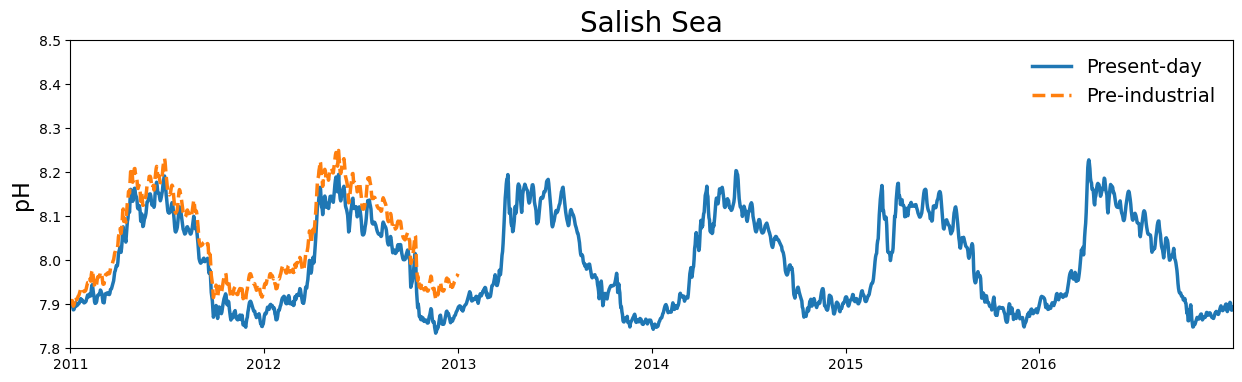

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
#blue, = ax.plot(times_noI, noI_pH, '-', c='k', linewidth=2)
#bluedsh, = ax.plot(times_PI_noI, PI_noI_pH, '--', c='k')
orange, = ax.plot(times_Lb80, Lb80_pH, '-', c='tab:blue', linewidth=2.5)
orangedsh, = ax.plot(times_PI_Lb80, PI_Lb80_pH, '--', c='tab:orange',linewidth=2.5)

ax.legend([orange,orangedsh], #blue,bluedsh,
          [ "Present-day", 'Pre-industrial'],fontsize=14,frameon=False); #"no Impact",'pre-industrial',
ax.set_xlim((dt.datetime(2011, 1, 1), dt.datetime(2016, 12, 31)))
#ax.grid();
ax.set_title('Salish Sea',fontsize=20)
ax.set_ylabel('pH',fontsize=16)
ax.set_ylim(7.8,8.5)

#plt.savefig('PDvsPI_pH_SalishSea.png', bbox_inches='tight',dpi=1000,transparent=False)

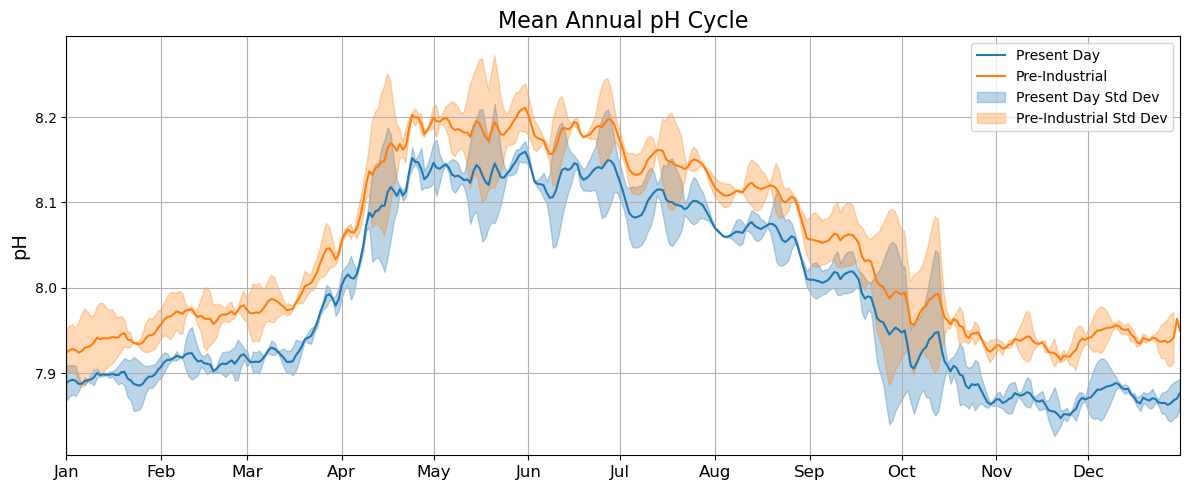

In [20]:

# Step 1: Build DataFrame
pres = pd.DataFrame({'pH': Lb80_pH}, index=pd.to_datetime(times_Lb80))
PI = pd.DataFrame({'PI_pH': PI_Lb80_pH}, index=pd.to_datetime(times_PI_Lb80))

# Step 2: Filter years 2015–2018 (← change back from 2011 when ready)
pres_filtered = pres.loc[(pres.index.year >= 2011) & (pres.index.year <= 2012)].copy()
PI_filtered = PI.loc[(PI.index.year >= 2011) & (PI.index.year <= 2012)].copy()

# Remove NaNs before grouping
pres_filtered = pres_filtered.dropna(subset=['pH'])
PI_filtered = PI_filtered.dropna(subset=['PI_pH'])

# Step 3: Group by day of year
pres_filtered['dayofyear'] = pres_filtered.index.dayofyear
PI_filtered['dayofyear'] = PI_filtered.index.dayofyear

# Group and aggregate
pres_grouped = pres_filtered.groupby('dayofyear')['pH']
PI_grouped = PI_filtered.groupby('dayofyear')['PI_pH']

pres_mean_pH = pres_grouped.mean()
pres_std_pH = pres_grouped.std()

PI_mean_pH = PI_grouped.mean()
PI_std_pH = PI_grouped.std()

# Step 3.5: Reindex to ensure all 365 days are present
doy_index = pd.Index(range(1, 366), name='dayofyear')  # Excludes leap day
pres_mean_pH = pres_mean_pH.reindex(doy_index)
pres_std_pH = pres_std_pH.reindex(doy_index)

PI_mean_pH = PI_mean_pH.reindex(doy_index)
PI_std_pH = PI_std_pH.reindex(doy_index)

# Step 4: Build fake dates for x-axis ticks, anchored to 2001 (non-leap year)
xticks = pd.to_datetime(doy_index, format='%j').to_series()
xticks = xticks.apply(lambda d: d.replace(year=2001))

# Step 5: Plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(xticks, pres_mean_pH, label='Present Day', color='tab:blue')
ax.fill_between(xticks, pres_mean_pH - pres_std_pH, pres_mean_pH + pres_std_pH, 
                color='tab:blue', alpha=0.3, label='Present Day Std Dev')

ax.plot(xticks, PI_mean_pH, label='Pre-Industrial', color='tab:orange')
ax.fill_between(xticks, PI_mean_pH - PI_std_pH, PI_mean_pH + PI_std_pH, 
                color='tab:orange', alpha=0.3, label='Pre-Industrial Std Dev')

# Format x-axis to show months only
ax.set_xlim([pd.Timestamp('2001-01-01'), pd.Timestamp('2001-12-31')])
ax.set_xticks(pd.date_range('2001-01-01', '2001-12-31', freq='MS'))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)

# Labels, title
ax.set_title('Mean Annual pH Cycle', fontsize=16)
ax.set_ylabel('pH', fontsize=14)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [21]:
Diff_pH=(Lb80_pH[0:364]-PI_Lb80_pH[0:364])

In [22]:
Diff_pH.min()

-0.07824612307452483

In [23]:
Diff_pH.max()

-0.002441786335277918

In [24]:
Diff_pH.mean()

-0.04259959441060538